In [1]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('data/maindata.csv', dtype={'price_string_unf': 'object'})

# Dask is faster for larger datasets but it doesnt show inline output, so i've not used it here
# daskdf = dd.read_csv('data/maindata.csv', dtype={'price_string_unf': 'object'})

In [3]:
df.shape

(13730000, 6)

In [4]:
df.describe()

,uuid,price_string,price_string_unf,product_type,level_1,category
count,13730000,5510000,310000,13720000,13680000,13720000
unique,1373,248,26,321,595,13
top,638744a4-b0ae-4166-8cb6-5c063c862036,$0.00,$6.75,U2NydWJzIGFuZCBjbGVhbmluZyBjbG90aHM,U3dlYXRzaGlydA,Q2xvdGhpbmcgYW5kIEFjY2Vzc29yaWVz
freq,10000,240000,30000,200000,90000,3910000


## *Question 1*
Products without prices

In [5]:
# Faster, just count. True == null, False == price exists
df['price_string'].isna().value_counts()

True     8220000
False    5510000
Name: price_string, dtype: int64

Text(0.5, 1.0, 'Number of products with and without prices')

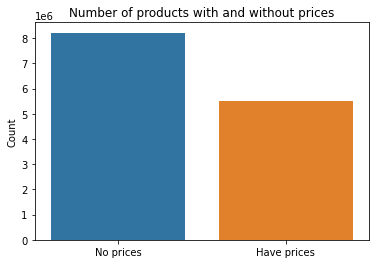

In [31]:
# One way to graph this data
x = df['price_string'].isna().value_counts()

sns.barplot(x=['No prices','Have prices'], y=x.values)
plt.ylabel('Count')
plt.title("Number of products with and without prices")

In [6]:
# Slower, returns data. This df has all products without price_string
noprices = df[df['price_string'].isna()]
noprices.shape

(8220000, 6)

### There are 8,220,000 products without prices
All products without price are stored in noprices.

In [7]:
num_hasprices = df.shape[0] - noprices.shape[0]
num_noprices = noprices.shape[0]

Text(0.5, 1.0, 'Number of products with and without prices')

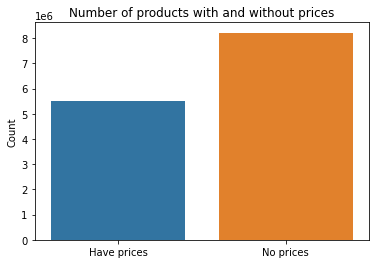

In [30]:
# Another way to graph this data
sns.barplot(y=[num_hasprices, num_noprices], x=['Have prices', 'No prices'])
plt.ylabel('Count')
plt.title("Number of products with and without prices")

## *Question 2*
Count of products without prices and with prices in each Product Type, Category,
Level 1

### Function used to generate the noprice hasprice dataframes, along with graph, based on input

In [9]:
# In the previous commit I had created variables for each subquestion, but I realised its a lot easier like this.
# I have ommitted xtick labels in the graphs so that it doesnt become a mess

def count_prods(criteria):
    grpby_df = df.groupby(criteria)
    hasprice = grpby_df.count()
    hasprice.rename(columns={"price_string": "hasprice"}, inplace=True)
    totalsize = grpby_df.size()
    noprice = totalsize - hasprice.hasprice
    total_price_df = pd.DataFrame(grpby_df.groups.keys(), columns=[criteria])
    total_price_df.set_index([criteria])
    total_price_df['hasprice'] = hasprice.hasprice.values
    total_price_df['noprice'] = noprice.values
    total_price_df.sort_values('hasprice', inplace=True)
    total_price_df.plot(kind='bar', stacked=True)
    plt.xticks(rotation=90)
    plt.xlabel(criteria)
    plt.ylabel('Count')
    plt.tick_params(axis='x', bottom=False, labelbottom=False)
    plt.show()
    return noprice, hasprice.hasprice

### Product Type

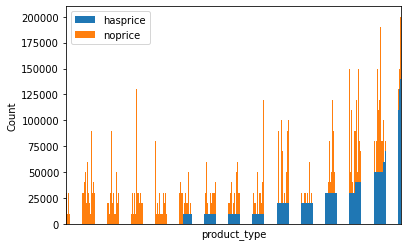

In [10]:
noprice_prodtype,hasprice_prodtype = count_prods('product_type')

In [11]:
# For all subquestions I've only returned the first 5 elements of the dataframes. 
# All values are available in noprice and hasprice dataframes

print("\nCount of products with no prices for each product type\n")
print(noprice_prodtype.head())
print("\nCount of products having prices for each product type\n")
print(hasprice_prodtype.head())


Count of products with no prices for each product type

product_type
Q0FUIExJVFRFUg            30000
Q29mZmVlIEJlYW5z          50000
Q29mZmVlIEZpbHRlcnM       10000
Q29uZGl0aW9uZXIgSGFpcg    20000
Q29va2llcw                30000
dtype: int64

Count of products having prices for each product type

product_type
Q0FUIExJVFRFUg                0
Q29mZmVlIEJlYW5z          30000
Q29mZmVlIEZpbHRlcnM           0
Q29uZGl0aW9uZXIgSGFpcg    10000
Q29va2llcw                    0
Name: hasprice, dtype: int64


### Category

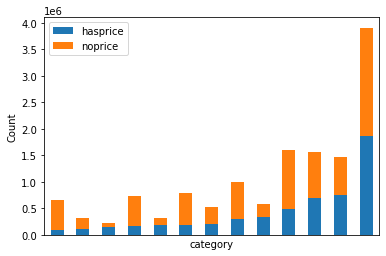

In [12]:
noprice_category, hasprice_category = count_prods('category')


In [13]:
print("\nCount of products with no prices for each category\n")
print(noprice_category.head())
print("\nCount of products having  prices for each category\n")
print(hasprice_category.head())


Count of products with no prices for each category

category
Q2xvdGhpbmcgYW5kIEFjY2Vzc29yaWVz    2050000
QXJ0IHN1cHBsaWVz                     130000
QmFieWNhcmU                          570000
RWxlY3Ryb25pY3M                      210000
SG91c2Vob2xkIGFuZCBDbGVhbmluZw       870000
dtype: int64

Count of products having  prices for each category

category
Q2xvdGhpbmcgYW5kIEFjY2Vzc29yaWVz    1860000
QXJ0IHN1cHBsaWVz                     190000
QmFieWNhcmU                           90000
RWxlY3Ryb25pY3M                      110000
SG91c2Vob2xkIGFuZCBDbGVhbmluZw       700000
Name: hasprice, dtype: int64


### Level 1


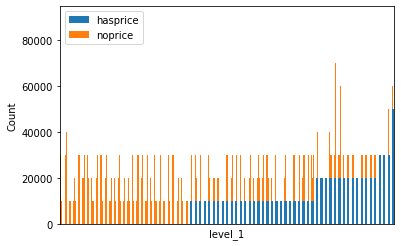

In [14]:
noprice_level1, hasprice_level1 = count_prods('level_1')


In [15]:
print("\nCount of products with no prices for each level_1\n")
print(noprice_level1.head())
print("\nCount of products having prices for each level_1\n")
print(hasprice_level1.head())


Count of products with no prices for each level_1

level_1
MTAgQ3Vw                0
MjAgQ3Vw                0
MjAgUGludHM         20000
MzAgQ3Vw                0
MzAtIDM1IFBpbnRz    10000
dtype: int64

Count of products having prices for each level_1

level_1
MTAgQ3Vw            10000
MjAgQ3Vw            10000
MjAgUGludHM         10000
MzAgQ3Vw            10000
MzAtIDM1IFBpbnRz    10000
Name: hasprice, dtype: int64


## *Question 3*
Correct Product Prices in the correct format (eg: $56) wherever possible and
separate them into currency and value columns

In [16]:
# Condition that checks if a value has a $ anywhere except the start
regex_flag = df['price_string'].str.contains('\d+\$\d*')

# if there isnt a $, the flag stores NaN. This replaces NaN with false so we can use it as a condition
tempe = regex_flag.fillna(False)

# Returns all rows where $ is present apart from the [0]th position.
# No rows are returned, which means all rows are either in $ddd or ddd format
# This was just to see if my replacement logic was valid for the data or if there were outliers
df[tempe]

,uuid,price_string,price_string_unf,product_type,level_1,category


In [17]:
# function that converts non-null string values to a $ddd format (d is a digit). If null, returns NaN

def add_doll(price):
    if pd.isnull(price):
        return np.nan
    else:
        if str(price)[0]!='$':
            return '$'+str(price)
        return str(price)

In [18]:
value_df = df.copy()

# Here we drop all NaN values in the price column, but can comment this out if needed

value_df = value_df[value_df['price_string'].notna()]

In [19]:
value_df['currency'] = value_df['price_string'].apply(add_doll)
value_df['value'] = value_df['currency'].apply(lambda x: float(str(x).replace('$', '')))

In [20]:
# This is the original dataframe with columns for currency and value, as per the given instructions
value_df.head()

,uuid,price_string,price_string_unf,product_type,level_1,category,currency,value
2,acbd66ff-79f8-467a-91f9-108a45af5626,$19.95,NaN,R3VtbWllcyB2aXRhbWlucyBhbmQgbWluZXJhbHMgZm9yIG...,SW1tdW5pdHkgZ3VtbWllcw,SGVhbHRo,$19.95,19.95
3,963915d6-b2e3-4098-b242-9410593cf205,$92.00,NaN,U2VydW1z,RmFjZSBTZXJ1bQ,YmVhdXR5IGFuZCBwZXJzb25hbCBjYXJl,$92.00,92.00
4,b5b68f3c-b1e0-40e5-8ee5-e2f7236c1daf,11.50,NaN,RWF0aW5nIFV0ZW5zaWxzL0N1dGxlcnk,Q2hvcHN0aWNrcw,a2l0Y2hpbmcgYW5kIGRpbmluZw,$11.50,11.50
6,9599f1a9-d406-43eb-89f5-9b1c0af1ac9a,$24.99,NaN,TW9wcyBhbmQgYnJvb21z,TW9w,SG91c2Vob2xkIGFuZCBDbGVhbmluZw,$24.99,24.99
7,35799087-f6f4-4ca2-abfe-cbb5c27d2f1a,$148.00,NaN,V29tZW5zIFBhbnRz,V29tZW5zIFJlZ3VsYXIvQ2FzdWFsIFBhbnRz,Q2xvdGhpbmcgYW5kIEFjY2Vzc29yaWVz,$148.00,148.00


## Question 4
List out the categories with average price of product.

In [21]:
# Create a dataframe that has only categories and price values
category_df = value_df[['category', 'value']].copy()
category_df.head()


,category,value
2,SGVhbHRo,19.95
3,YmVhdXR5IGFuZCBwZXJzb25hbCBjYXJl,92.00
4,a2l0Y2hpbmcgYW5kIGRpbmluZw,11.50
6,SG91c2Vob2xkIGFuZCBDbGVhbmluZw,24.99
7,Q2xvdGhpbmcgYW5kIEFjY2Vzc29yaWVz,148.00


In [22]:
value_grpby_category = category_df.groupby('category')
avg_price_by_category = value_grpby_category.mean()
avg_price_by_category.rename(columns={'value': 'average_price'}, inplace=True)

In [23]:
# Dataframe with average price of products by category
avg_price_by_category

,average_price
category,
Q2xvdGhpbmcgYW5kIEFjY2Vzc29yaWVz,125.413871
QXJ0IHN1cHBsaWVz,19.471053
QmFieWNhcmU,163.688889
RWxlY3Ryb25pY3M,60.258182
SG91c2Vob2xkIGFuZCBDbGVhbmluZw,76.199000
SGVhbHRo,32.557586
VG95cyBhbmQgR2FtZXM,32.448947
VG9vbHMgYW5kIGhvbWUgaW1wcm92ZW1lbnQ,82.223500
YmVhdXR5IGFuZCBwZXJzb25hbCBjYXJl,34.745067


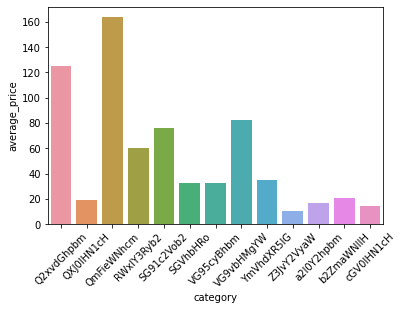

In [24]:
# Plotting the avg price per category. Truncated category name to 10 letters to maintain readability. 
# (not like the category names are readable in any case)

sns.barplot(x=avg_price_by_category.index.str.slice(0,10),y=avg_price_by_category.average_price)
plt.xticks(rotation=45)
plt.show()